## About the data:
polyps are precursors to colorectal cancer, and is found in nearly half of the individuals at age 50 having a screening colonoscopy, and are increasing with age. Colonoscopy is the gold standard for detection and assessment of these polyps with subsequent biopsy and removal of the polyps. Early disease detection has a huge impact on survival from colorectal cancer, and polyp detection is therefore important. In addition, several studies have shown that polyps are often overlooked during colonoscopies, with polyp miss rates of 14%-30% depending on the type and size of the polyps. Increasing the detection of polyps has been shown to decrease risk of colorectal cancer. Thus, automatic detection of more polyps at an early stage can play a crucial role in improving both prevention of and survival from colorectal cancer. This is the main motivation behind the development of a Kvasir-SEG dataset.

The Kvasir-SEG dataset contains 1000 polyp images and their corresponding ground truth from the Kvasir Dataset v2. The resolution of the images contained in Kvasir-SEG varies from 332x487 to 1920x1072 pixels.

# Importing Libraries

In [1]:
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import plotly.express as px
import plotly.io as pio
from plotly.offline import iplot
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, auc

pio.templates["plotly_dark"].layout.colorway = px.colors.qualitative.Set2
pio.templates.default = "plotly_dark" 

# Loading images and masks

In [2]:
images_dir = r"/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/images"
masks_dir = r"/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/masks"

In [3]:
def load_image_and_mask(image_path,mask_path):
    image_size = (256,256)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,image_size)
    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask,image_size)
    mask = np.expand_dims(mask,axis=-1)
    mask = np.where(mask>0,1,0).astype(np.float32)
    
    return img,mask

In [4]:
def load_dataset(image_paths,mask_paths):
    imgs = []
    masks = []
    for i,m in zip(image_paths,mask_paths):
        img,mask  = load_image_and_mask(i,m)
        imgs.append(img)
        masks.append(mask)
    
    return np.array(imgs),np.array(masks)

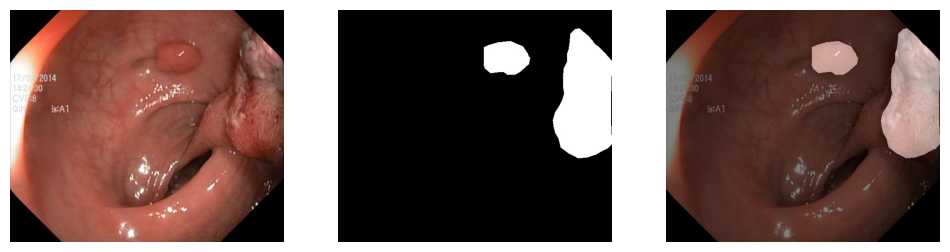

In [5]:
img_p = r"/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/images/cju0roawvklrq0799vmjorwfv.jpg"
msk_p = r"/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/masks/cju0roawvklrq0799vmjorwfv.jpg"
img = cv2.imread(img_p)
msk = cv2.imread(msk_p,cv2.IMREAD_GRAYSCALE)
plt.figure(figsize= (12,15))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(msk, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.imshow(cv2.cvtColor(msk, cv2.COLOR_BGR2RGB),alpha = 0.5)
plt.axis("off")

plt.show()

In [6]:
images_paths = [os.path.join(images_dir,f) for f in os.listdir(images_dir)]
masks_paths = [os.path.join(masks_dir,f) for f in os.listdir(masks_dir)]

In [7]:
len(images_paths)

1000

In [8]:
len(masks_paths)

1000

In [9]:
images,masks = load_dataset(images_paths,masks_paths)

# Creating U-Net model

In [10]:
def u_net():
    inputs = layers.Input(shape = (256,256,3))
    inputs = layers.Rescaling(scale= 1./255)(inputs)
    
    #Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(p4)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(c5)
    p5 = layers.MaxPooling2D((2, 2))(c5)
    
    c6 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(p5)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(c6)


    # Decoder
    u7 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c5])
    c7 = layers.Conv2D(512, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Conv2D(512, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(c7)

    
    u8 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c4])
    c8 = layers.Conv2D(256, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Conv2D(256, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(c8)


    u9 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same',kernel_initializer = "he_normal")(c8)
    u9 = layers.concatenate([u9, c3])
    c9 = layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(c9)


    u10 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same',kernel_initializer = "he_normal")(c9)
    u10 = layers.concatenate([u10, c2])
    c10 = layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(u10)
    c10 = layers.BatchNormalization()(c10)
    c10 = layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(c10)

    
    u11 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c10)
    u11 = layers.concatenate([u11, c1])
    c11 = layers.Conv2D(32, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(u11)
    c11 = layers.BatchNormalization()(c11)
    c11 = layers.Conv2D(16, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(c11)

    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)
    
    model = models.Model(inputs=[inputs],outputs = [outputs])
    model.compile(optimizer = 'adam', loss = "binary_crossentropy",metrics = ["accuracy",tf.metrics.BinaryIoU(target_class_ids=(0, 1))])
    
    return model

In [11]:
model = u_net()

In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_1CLONE │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ keras_tensor_1CL… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[2][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[2][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[2]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[2][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[2][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[2][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[2][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_6[2][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[2][0]  

 Total params: 31,101,889 (118.64 MB)

 Trainable params: 31,095,873 (118.62 MB)

 Non-trainable params: 6,016 (23.50 KB)

# Training Model

In [13]:
check_point = ModelCheckpoint('U-Net.keras', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.7,          
    patience=5,          
    min_lr=1e-7,        
    verbose=1       
)

In [14]:
history = model.fit(x=images,y=masks, epochs=50, validation_split = 0.1, batch_size = 16 ,callbacks = [check_point,reduce_lr])

Epoch 1/50


I0000 00:00:1729054158.756253      71 service.cc:145] XLA service 0x7e5720003000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729054158.756337      71 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/57 ━━━━━━━━━━━━━━━━━━━━ 31:13 33s/step - accuracy: 0.4355 - binary_io_u: 0.2397 - loss: 0.8926

I0000 00:00:1729054181.692048      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 ━━━━━━━━━━━━━━━━━━━━ 59s 460ms/step - accuracy: 0.7765 - binary_io_u: 0.4203 - loss: 0.4640 - val_accuracy: 0.8333 - val_binary_io_u: 0.4181 - val_loss: 9.3455 - learning_rate: 0.0010
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 205ms/step - accuracy: 0.8582 - binary_io_u: 0.5277 - loss: 0.3231 - val_accuracy: 0.8392 - val_binary_io_u: 0.4229 - val_loss: 3.3718 - learning_rate: 0.0010
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.8732 - binary_io_u: 0.5665 - loss: 0.2986 - val_accuracy: 0.8085 - val_binary_io_u: 0.4534 - val_loss: 0.8967 - learning_rate: 0.0010
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.8798 - binary_io_u: 0.5760 - loss: 0.2888 - val_accuracy: 0.8141 - val_binary_io_u: 0.4818 - val_loss: 0.5173 - learning_rate: 0.0010
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step - accuracy: 0.8790 - binary_io_u: 0.5904 - loss: 0.2860 - val_accuracy: 0.8616 - val_binary_io_u: 0.5911 - val_loss: 0.3427 - learning_rate: 0.0010
Epoch 6/

# Evaluating model

In [15]:
vals = pd.DataFrame(history.history)
vals = vals.rename(columns={"loss":"Train Loss","val_loss":"Validation Loss",\
                            "accuracy":"Train Accuracy","val_accuracy":"Validation Accuracy",
                             "binary_io_u":"Train IoU","val_binary_io_u":"Validation IoU"
                           })

In [16]:
vals

,Train Accuracy,Train IoU,Train Loss,Validation Accuracy,Validation IoU,Validation Loss,learning_rate
0,0.824484,0.391074,0.387001,0.833266,0.418114,9.345544,0.001000
1,0.860614,0.485884,0.321522,0.839246,0.422922,3.371792,0.001000
2,0.870957,0.516555,0.305046,0.808486,0.453419,0.896701,0.001000
3,0.876037,0.533965,0.292683,0.814077,0.481833,0.517272,0.001000
4,0.880779,0.544345,0.284052,0.861590,0.591111,0.342676,0.001000
5,0.887642,0.571374,0.268358,0.844731,0.617671,0.380336,0.001000
6,0.889837,0.577087,0.263548,0.865840,0.589269,0.318993,0.001000
7,0.896871,0.597345,0.248985,0.874385,0.554970,0.362806,0.001000
8,0.898610,0.602794,0.244442,0.885602,0.663267,0.280989,0.001000
9,0.904399,0.624351,0.234374,0.870427,0.646814,0.390144,0.001000


In [17]:
iplot(px.line(
    data_frame = vals,
    y = ["Train Accuracy","Validation Accuracy"],
    labels = {"index":"epochs","value":"accuracy"},
    title = "Accuracy"
))

In [18]:
iplot(px.line(
    data_frame = vals,
    y = ["Train Loss","Validation Loss"],
    labels = {"index":"epochs","value":"Loss"},
    title = "Loss"
))

In [19]:
iplot(px.line(
    data_frame = vals,
    y = ["Train IoU","Validation IoU"],
    labels = {"index":"epochs","value":"IoU"},
    title = "IoU(Intersection over Union)"
))

# Predicting an image from segmentation dataset

(-0.5, 255.5, 255.5, -0.5)

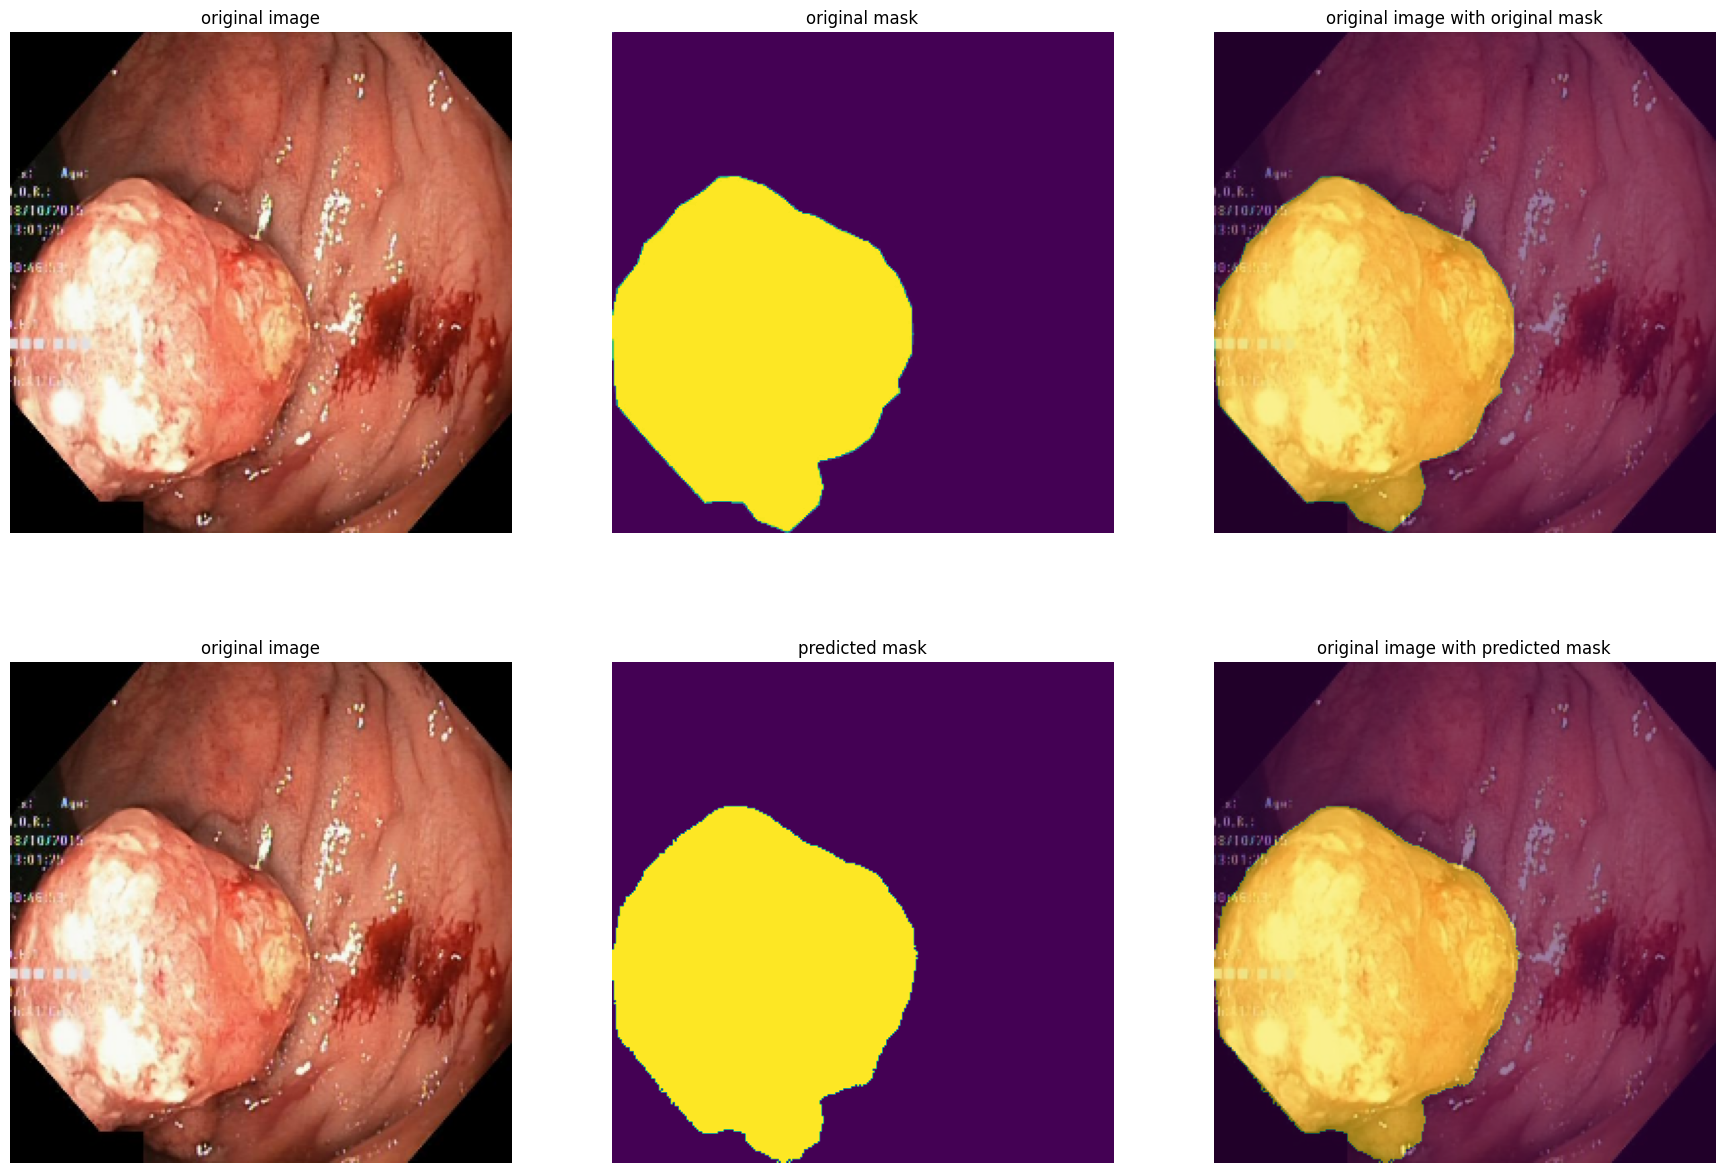

In [20]:
img = cv2.imread(r"/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/images/cju0u2g7pmnux0801vkk47ivj.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(256,256))
img = np.array(img)
msk = cv2.imread("/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/masks/cju0u2g7pmnux0801vkk47ivj.jpg",\
                 cv2.IMREAD_GRAYSCALE)
msk = cv2.resize(msk,(256,256))
predictions = model.predict(np.expand_dims(img, axis=0), verbose=0)
predictions = tf.where(predictions > 0.5, 1.0, 0.0)


plt.figure(figsize=(22, 15))
plt.subplot(2, 3, 1)
plt.title("original image")
plt.imshow(img)
plt.axis("off")

plt.subplot(2, 3, 2)
plt.title("original mask")
plt.imshow(msk)
plt.axis("off")

plt.subplot(2, 3, 3)
plt.title("original image with original mask")
plt.imshow(img)
plt.imshow(np.squeeze(msk),alpha=0.5)
plt.axis("off")

plt.subplot(2,3,4)
plt.title("original image")
plt.imshow(img)
plt.axis("off")

plt.subplot(2,3,5)
plt.title("predicted mask")
plt.imshow(np.squeeze(predictions))
plt.axis("off")

plt.subplot(2, 3, 6)
plt.title("original image with predicted mask")
plt.imshow(img)
plt.imshow(np.squeeze(predictions),alpha=0.5)
plt.axis("off")

# Predicting an image from the classification dataset

(-0.5, 255.5, 255.5, -0.5)

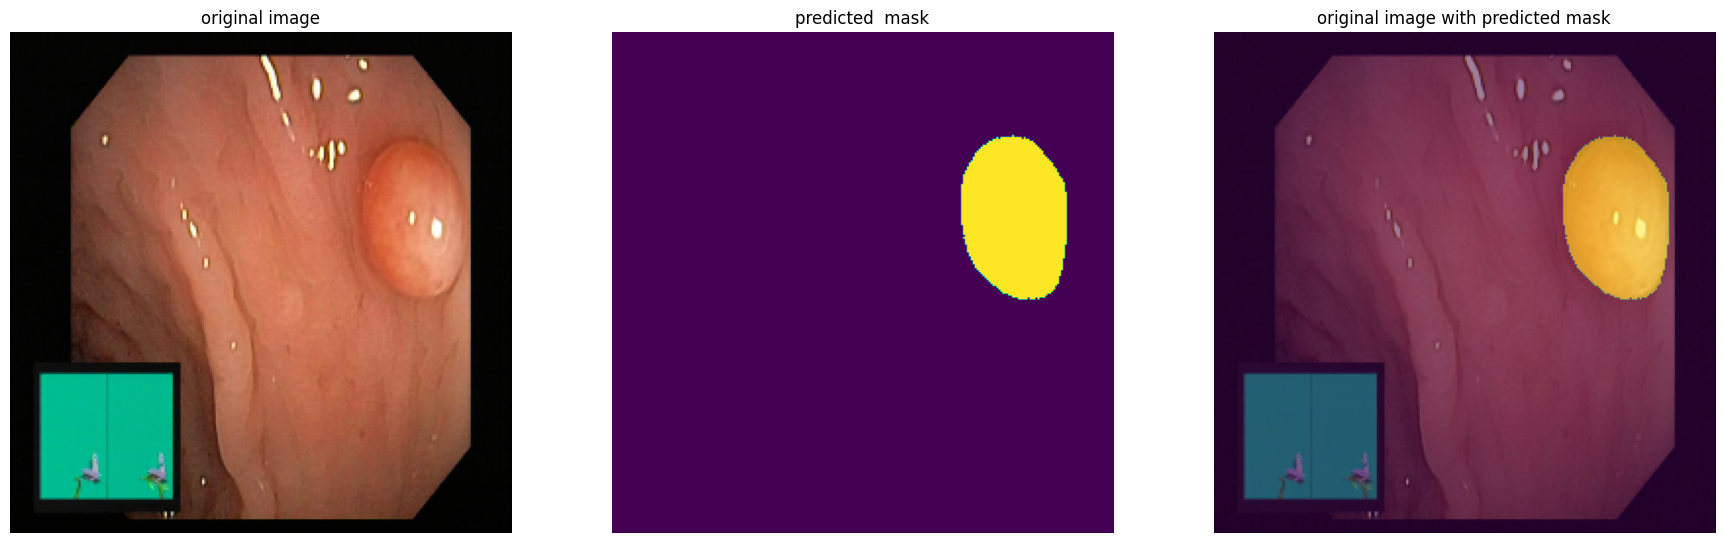

In [21]:
img = cv2.imread(r"/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-dataset/kvasir-dataset/polyps/0014d89e-5afa-4186-99f9-4400c8c58a18.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(256,256))
predictions = model.predict(np.expand_dims(img, axis=0), verbose=0)
predictions = tf.where(predictions > 0.5, 1.0, 0.0)


plt.figure(figsize=(22, 15))
plt.subplot(1, 3, 1)
plt.title("original image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("predicted  mask")
plt.imshow(np.squeeze(predictions))
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("original image with predicted mask")
plt.imshow(img)
plt.imshow(np.squeeze(predictions),alpha=0.5)
plt.axis("off")